## Movie Recommendation using Netflix data

The goal of our project will be to build a movie recommender based on the Netflix Prize data. In this first notebook we will be loading, exploring and cleaning our dataset so that we can use it later.

In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load dataset (Here we only the first third of the data, there are two more files, but for the preparation purposes
# we are loading only one. This speeds things up considerably.)
df1 = pd.read_csv('combined_data_1.txt', header = None, names = ['User_Id', 'Rating'], usecols = [0,1])

df = df1

####  Quick visualisation of the data.
Data is currently structured as follows:
ID of movie followed by user ratings of this movie. 
In these first five lines we see 4 ratings, respectively 3, 5, 4 and 4 out of 5 stars for the movie with ID=1.
We will transform this structure so that instead of having the movie ID as a line, we have it as an additional column

In [3]:
df1.head() # 

,User_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


## Clean Data and Transform Movie Id's from row value to column

In [4]:
# Remove rows were there is no rating
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length

last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df.loc[:,'Movie_Id'] = movie_np.astype(int)
df.loc[:,'User_Id'] = df['User_Id'].astype(int)
df.head()

/home/cernewein/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/cernewein/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,User_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


## Statistics

Below are the number of unique movies and the number of unique users. For our purposes it is good to have as many ratings per movie and ratings per user as possible

In [7]:
len(df['Movie_Id'].unique()) # Number of movies

4499

In [8]:
len(df['User_Id'].unique()) # Number of users

470758

Next we are looking at the number of ratings per movie, as can be seen in the next cell, there are huge differences between the number of ratings from one movie to another. This difference can be as big as 3 orders of magnitude. The ratings aren't well distributed amongst the movies, this might have an impact on our model.

In [12]:
df.groupby('Movie_Id').count()['Rating']

Movie_Id
1          547
2          145
3         2012
4          142
5         1140
6         1019
7           93
8        14910
9           95
10         249
11         198
12         546
13         125
14         118
15         290
16        2699
17        7108
18       10722
19         539
20         116
21         218
22         203
23         615
24        1333
25        1207
26        5861
27         273
28       39752
29         523
30      118413
         ...  
4470       416
4471       105
4472    101118
4473       541
4474      4241
4475       101
4476       566
4477       276
4478      2551
4479     23884
4480       172
4481       224
4482      1639
4483      1032
4484      1276
4485      3180
4486       193
4487       118
4488     33175
4489      1404
4490     10258
4491       453
4492      9353
4493      6381
4494       130
4495       614
4496      9519
4497       714
4498       269
4499       428
Name: Rating, Length: 4499, dtype: int64

Below we compute the mean rating per movie. We again notice some big variations in between movies; the worst movie is rated under 1.5 on average while the best movie is rated over 4.5

In [17]:
mean_rating = df.groupby('Movie_Id').mean()['Rating']
print(mean_rating)
print(min(mean_rating))
print(max(mean_rating))

Movie_Id
1       3.749543
2       3.558621
3       3.641153
4       2.739437
5       3.919298
6       3.084396
7       2.129032
8       3.189805
9       2.621053
10      3.180723
11      3.030303
12      3.417582
13      4.552000
14      3.025424
15      3.286207
16      3.098555
17      2.903208
18      3.784369
19      3.324675
20      3.146552
21      3.463303
22      2.246305
23      3.556098
24      2.993998
25      3.970174
26      2.793721
27      3.527473
28      3.823254
29      3.598470
30      3.761842
          ...   
4470    3.689904
4471    2.942857
4472    3.693833
4473    3.042514
4474    3.225654
4475    3.148515
4476    3.876325
4477    3.724638
4478    3.650333
4479    3.736853
4480    3.447674
4481    3.254464
4482    2.788896
4483    3.336240
4484    4.003918
4485    3.453145
4486    2.839378
4487    2.203390
4488    3.554906
4489    3.502849
4490    3.168746
4491    3.150110
4492    2.643323
4493    3.135089
4494    2.584615
4495    3.478827
4496    3.763000
4497 

Number of ratings per user. Here we notice that some users have made over 200 ratings (one user apparently rated over 4000 movies !!), while others have only rated 1 movie. From these people that rated only one movie it will probably be harder to get any insights

In [19]:
user_ratings = df.groupby('User_Id').count()['Rating']
print(user_ratings)
print(min(user_ratings))
print(max(user_ratings))

User_Id
6          153
7          195
8           21
10          49
25           4
33          11
42          36
59          49
79         197
83          10
87          50
94          27
97         117
116         45
126         15
130          8
131         36
133          1
134        169
142         13
149          5
158         14
164         25
168          7
169         68
177          5
178          5
183         61
188        129
189          4
          ... 
2649267    210
2649268      7
2649285    233
2649288     55
2649296    177
2649299     39
2649308    143
2649311     48
2649323     35
2649326      5
2649328     76
2649331     59
2649335     87
2649336     85
2649337      9
2649343      1
2649351     24
2649370     64
2649375     36
2649376     34
2649378     72
2649379      2
2649384      7
2649388     77
2649401     30
2649404     12
2649409     10
2649421      3
2649426     74
2649429     62
Name: Rating, Length: 470758, dtype: int64
1
4467


In [20]:
mean_rating_user = df.groupby('User_Id').mean()['Rating']
print(mean_rating_user)
print(min(mean_rating_user))
print(max(mean_rating_user))

User_Id
6          3.333333
7          4.066667
8          4.000000
10         3.346939
25         3.500000
33         3.454545
42         3.944444
59         4.040816
79         3.507614
83         4.500000
87         3.640000
94         3.407407
97         3.230769
116        4.111111
126        4.800000
130        4.375000
131        3.000000
133        3.000000
134        4.745562
142        3.538462
149        4.600000
158        3.500000
164        3.640000
168        4.571429
169        3.720588
177        3.400000
178        3.400000
183        3.688525
188        3.418605
189        4.500000
             ...   
2649267    3.800000
2649268    4.714286
2649285    3.072961
2649288    4.018182
2649296    3.333333
2649299    4.076923
2649308    3.811189
2649311    4.104167
2649323    3.285714
2649326    2.400000
2649328    3.723684
2649331    3.864407
2649335    4.045977
2649336    3.482353
2649337    4.333333
2649343    4.000000
2649351    4.291667
2649370    3.828125
2649375    4

## Visualisations

(array([ 547.,  145., 2012., ..., 9519.,  714.,  697.]),
 array([   1,    2,    3, ..., 4497, 4498, 4499]),
 <a list of 4498 Patch objects>)

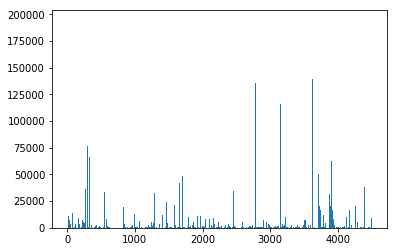

In [9]:
plt.hist(df['Movie_Id'], bins = list(df['Movie_Id'].unique()))

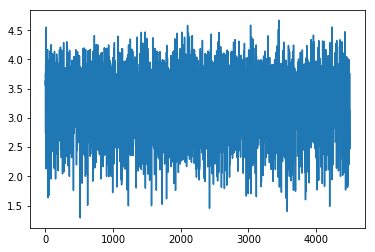

In [16]:
plt.plot(mean_rating.index,mean_rating.values)

Here we take a look at the number of ratings per value of rating, ie the number of ratings 1, ratings 2 etc..
We notice that overall the rating of the movies seems to be neutral to positive

Rating
1.0    0.046487
2.0    0.101401
3.0    0.287031
4.0    0.336153
5.0    0.228928
Name: User_Id, dtype: float64


<BarContainer object of 5 artists>

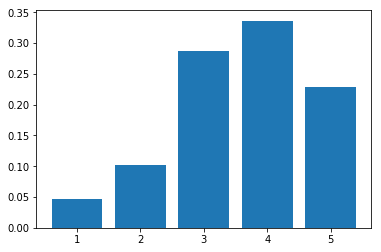

In [26]:
number_per_rating = df.groupby('Rating').count()['User_Id']
print(number_per_rating/len(df))
plt.bar(number_per_rating.index,number_per_rating.values/len(df))

# Auxiliary dataset: movie titles with years

We also have another dataset, being the movie Ids with associated title and the year the movie was released. The release year could be an interesting feature to add to our analysis

In [27]:
df_title = pd.read_csv('./movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.head()

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


# Conclusion

The dataset is very large, we might have to limit ourselves to movies and users with a certain number of minimum ratings, depending if our computers will be able to handle the dataset with acceptable speed or not.

We have been able to find some interesting insights such as the number of ratings per user, per movie, the average rating per user, per movie as well as the number of ratings per rating value.

Our goal will be to build a model for recommending the movies, for doing so we could for example try to characterise a person based on the movies he likes (and finding characteristics of the movies, such as the type of the movie: romantic, adventure, thriller..), this would be a first step, where we would only model if a user is likely to like or dislike a movie, we could move further by trying to predict the rating a user would give a specific movie.